### Billboard dataset

This notebook matches the entries of the Billboard dataset with the entries of the WASABI database.

The steps are the following:

1. match the artists names. To do that, we mainly use the name_normalizer.py script developed by the authors of the Million song dataset. We modified some parts of the script to include some exceptions (e.g., two song titles differring only for stopwords, limiting the rotation of artist names).

2. for artists identified as having the same name, we run the same script to search for same title. 

The billboard dataset we are using contains the SpotifyID of the song. However, the match is not completely reliable (spotify id obtained by querying the Spotify API with the title and name of the song and artist). We will first start with showing how our approach works for the subset of songs of WASABI and BILLBOARD having the same spotify ID.


In [ ]:
!pip install python-Levenshtein

     |████████████████████████████████| 50 kB 2.9 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149859 sha256=e17bc0586fdb79c6156e57f8502d211d16971162e562ab4430adfd176e46c6eb
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [ ]:
# mount GDrive
from google.colab import drive
#drive.mount('/content/drive')
drive._mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load data billboard dataset
!cp /content/drive/MyDrive/Artistic_Content_Creation/WASABI_gender_experiments/WASABI_gender_experiments_definitive/data/kcmillersean-billboard-hot-100-1958-2017.zip .

# unzip billboard data
!unzip kcmillersean-billboard-hot-100-1958-2017.zip

Archive:  kcmillersean-billboard-hot-100-1958-2017.zip
  inflating: kcmillersean-billboard-hot-100-1958-2017/Hot 100 Audio Features.xlsx  
  inflating: kcmillersean-billboard-hot-100-1958-2017/Hot Stuff.csv  


In [ ]:
# load dataset
!cp -r "drive/MyDrive/Artistic_Content_Creation/WASABI_gender_experiments/WASABI_gender_experiments_definitive/dataset_10/data_lyrics_group_decades" .
!cp -r "drive/MyDrive/Artistic_Content_Creation/WASABI_gender_experiments/WASABI_gender_experiments_definitive/dataset_10/data_lyrics_person_decades" .

In [ ]:
# load cover/duplicates
!cp -r "drive/MyDrive/Artistic_Content_Creation/WASABI_gender_experiments/WASABI_gender_experiments_definitive/dataset_10/final_duplicates_and_covers.json" .

In [ ]:
# load utils
!cp "drive/MyDrive/Artistic_Content_Creation/WASABI_gender_experiments/utils/name_normalizer.py" .
!cp "drive/MyDrive/Artistic_Content_Creation/WASABI_gender_experiments/utils/eng_sklearn_stopwords.txt" .

In [ ]:
%pylab inline
import pandas as pd
import glob
from tqdm.notebook import tqdm
from datetime import datetime

import name_normalizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#from sparse_dot_topn import awesome_cossim_topn
from scipy import sparse

tqdm.pandas()

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# load the duplicated lyrics of WASABI
song_duplicates = pd.read_json('final_duplicates_and_covers.json')
song_duplicates.head()

,song_id,duplicated_of,cover_of,is_duplicated,is_cover
0,5714deec25ac0d8aee5735f8,5714deec25ac0d8aee573522,None,True,False
1,5714dec625ac0d8aee3a5ee7,5714dec625ac0d8aee3a5d8d,None,True,False
2,5714ded925ac0d8aee493bfd,5714ded925ac0d8aee493af6,None,True,False
3,5714ded925ac0d8aee493c75,5714ded925ac0d8aee493af6,None,True,False
4,5714ded925ac0d8aee493ca1,5714ded925ac0d8aee493af6,None,True,False


In [ ]:
# load songs 

data_folders = ['data_lyrics_person_decades/', 'data_lyrics_group_decades/']

song_lyrics = []

for data_folder in data_folders:
    type_ = data_folder.split('_')[-2]
    for file in glob.glob(data_folder+'*_[!.]*.json.gz'): # skip songs with no dates

        data_chunk = pd.read_json(file, orient='records', lines=True, chunksize=5000 )
        for chunk in data_chunk:        

            chunk = chunk[['song_id', 'song_title', 'language_detect', 'lyrics', 'n_words', 'n_lines', 'artist_id', 'artist_name',
                            'song_pubdate_combined', 'song_year_combined', 'song_decade_combined', 'other_artist_info',
                           'urlSpotify']]
            song_lyrics.append(chunk)

song_lyrics = pd.concat(song_lyrics)
print('Total number of song lyrics: ', song_lyrics.shape[0])
song_lyrics.head()

Total number of song lyrics:  460339


,song_id,song_title,language_detect,lyrics,n_words,n_lines,artist_id,artist_name,song_pubdate_combined,song_year_combined,song_decade_combined,other_artist_info,urlSpotify
0,5714dec325ac0d8aee381b09,Tequila,english,I was at the bar with my drinking team\nAnd it...,505,74,56d7e9e36b60c09814f93faa,A.L.T.,,1992,1990,"{'n_albums': 4, 'n_songs': 27, 'languages': {'...",
1,5714dec325ac0d8aee381b1a,Audi 5000,english,[Verse: 1]\n\nI once knew a bitch named Merced...,464,55,56d7e9e36b60c09814f93faa,A.L.T.,1993-09-21,1993,1990,"{'n_albums': 4, 'n_songs': 27, 'languages': {'...",https://play.spotify.com/track/6iY2I3ZPsnVDZPp...
2,5714dec325ac0d8aee381b1e,17 Shots,english,[Verse: 1]\n\n17 shots in my clip\nI'm rolling...,487,59,56d7e9e36b60c09814f93faa,A.L.T.,,1993,1990,"{'n_albums': 4, 'n_songs': 27, 'languages': {'...",
3,5714dec325ac0d8aee386438,Compassion,english,Blessed are the poor in spirit\nfor theirs is ...,103,19,56d7ef2356847be81b3e8bce,Adrian Snell,1990-01-01,1990,1990,"{'n_albums': 6, 'n_songs': 101, 'languages': {...",
4,5714dec325ac0d8aee38643a,Goodbye October,english,Goodbye October\n\nGoodbye October\nLet me res...,163,26,56d7ef2356847be81b3e8bce,Adrian Snell,1990-01-01,1990,1990,"{'n_albums': 6, 'n_songs': 101, 'languages': {...",


In [ ]:
# get the spotify ID
song_lyrics.loc[:, 'SpotifyID'] = song_lyrics.urlSpotify.apply(lambda url: url.split("/")[-1])

In [ ]:
# load chart data
song_info = pd.read_excel('kcmillersean-billboard-hot-100-1958-2017/Hot 100 Audio Features.xlsx')
charts = pd.read_csv("kcmillersean-billboard-hot-100-1958-2017/Hot Stuff.csv")

# remove songs published before 1960 and after 2010
charts.loc[:, 'year'] = charts.WeekID.apply(lambda week: int(week.split("/")[-1]))
charts = charts[(charts.year>=1959)&(charts.year<=2010) ]
song_info = song_info[song_info.SongID.isin(charts.SongID.values)]

# remove duplicate songID (it means they have same title and artist name)
song_info = song_info.drop_duplicates(subset=['SongID'])
print('Number of songs in billboard: ', song_info.shape[0])

song_info.head(2)

Number of songs in billboard:  24180


,SongID,Performer,Song,spotify_genre,spotify_track_id,spotify_track_preview_url,spotify_track_album,spotify_track_explicit,spotify_track_duration_ms,spotify_track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
52,All I Want For Christmas Is YouMariah Carey,Mariah Carey,All I Want For Christmas Is You,"['dance pop', 'pop', 'r&b', 'urban contemporary']",0bYg9bo50gSsH3LtXe2SQn,https://p.scdn.co/mp3-preview/ab4f06069148ef85...,Merry Christmas,0.0,241106.0,95.0,0.335,0.625,7.0,-7.462,1.0,0.0386,0.164,0.0,0.0708,0.346,150.277,4.0
65,Rockin' Around The Christmas TreeBrenda Lee,Brenda Lee,Rockin' Around The Christmas Tree,"['adult standards', 'brill building pop']",2EjXfH91m7f8HiJN1yQg97,NaN,Merry Christmas From Brenda Lee,0.0,126266.0,90.0,0.589,0.472,8.0,-8.749,1.0,0.0502,0.614,0.0,0.5050,0.898,67.196,4.0


In [ ]:
# for each song, get when it entered in the chart the first time
charts.loc[:, 'week'] = charts.WeekID.apply(lambda date: datetime.strptime(date, "%m/%d/%Y"))

charts_first_week = charts.groupby('SongID').apply(lambda rows: rows.sort_values('week').iloc[0]).reset_index(drop=True)

# merge the week to the song_info table
song_info = song_info.merge(charts_first_week[['SongID', 'WeekID', 'week']], on='SongID', how='left')

In [ ]:
# how many missing spotify Ids
song_info.spotify_track_id.isna().sum()

4456

In [ ]:
# how many duplicated spotify ids
song_info.spotify_track_id.dropna().duplicated().sum()

74

In [ ]:
# examples of spotify ids duplicates
song_info[song_info.spotify_track_id.duplicated(False)
         ].dropna(subset=['spotify_track_id']).sort_values('spotify_track_id').iloc[:10]

,SongID,Performer,Song,spotify_genre,spotify_track_id,spotify_track_preview_url,spotify_track_album,spotify_track_explicit,spotify_track_duration_ms,spotify_track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,WeekID,week
16022,Bongo Bongo BongoPreston Epps,Preston Epps,Bongo Bongo Bongo,[],0DpjGs3EbsI1TKiYSSeTRF,NaN,Bongo Bongo Bongo,0.0,126320.0,5.0,0.341,0.994,4.0,-9.022,1.0,0.0708,0.572,0.87900,0.3910,0.581,168.714,4.0,8/13/1960,1960-08-13
2167,Bongo RockPreston Epps,Preston Epps,Bongo Rock,[],0DpjGs3EbsI1TKiYSSeTRF,NaN,Bongo Bongo Bongo,0.0,126320.0,5.0,0.341,0.994,4.0,-9.022,1.0,0.0708,0.572,0.87900,0.3910,0.581,168.714,4.0,5/16/1959,1959-05-16
10053,"Shining StarEarth, Wind & Fire","Earth, Wind & Fire",Shining Star,"['disco', 'funk', 'jazz funk', 'motown', 'quie...",0RgcOUQg4qYAEt9RIdf3oB,https://p.scdn.co/mp3-preview/4826dc0c324e562c...,That's The Way Of The World,0.0,170160.0,62.0,0.676,0.692,9.0,-13.093,1.0,0.0520,0.668,0.00915,0.1300,0.799,102.516,4.0,2/15/1975,1975-02-15
15546,"StarEarth, Wind & Fire","Earth, Wind & Fire",Star,"['disco', 'funk', 'jazz funk', 'motown', 'quie...",0RgcOUQg4qYAEt9RIdf3oB,https://p.scdn.co/mp3-preview/4826dc0c324e562c...,That's The Way Of The World,0.0,170160.0,62.0,0.676,0.692,9.0,-13.093,1.0,0.0520,0.668,0.00915,0.1300,0.799,102.516,4.0,12/22/1979,1979-12-22
5803,Let A Man Come In And Do The Popcorn (Part Two...,James Brown,Let A Man Come In And Do The Popcorn (Part Two),"['funk', 'motown', 'soul']",0hA8G8smCwi1h1nmxyRqT3,NaN,It's A New Day - Let A Man Come In,0.0,430120.0,12.0,0.637,0.702,1.0,-3.276,1.0,0.0632,0.284,0.00043,0.0638,0.918,98.711,4.0,12/20/1969,1969-12-20
1937,Let A Man Come In And Do The Popcorn (Part One...,James Brown,Let A Man Come In And Do The Popcorn (Part One),"['funk', 'motown', 'soul']",0hA8G8smCwi1h1nmxyRqT3,NaN,It's A New Day - Let A Man Come In,0.0,430120.0,12.0,0.637,0.702,1.0,-3.276,1.0,0.0632,0.284,0.00043,0.0638,0.918,98.711,4.0,10/11/1969,1969-10-11
13202,Surfin' U.S.A.The Beach Boys,The Beach Boys,Surfin' U.S.A.,"['baroque pop', 'brill building pop', 'folk ro...",0wz1LjDb9ZNEYwOmDJ3Q4b,NaN,Surfin' USA (Remastered),0.0,149373.0,72.0,0.550,0.854,3.0,-5.968,1.0,0.0360,0.661,0.00000,0.1120,0.965,159.231,4.0,3/23/1963,1963-03-23
17878,SurfinThe Beach Boys,The Beach Boys,Surfin,"['baroque pop', 'brill building pop', 'folk ro...",0wz1LjDb9ZNEYwOmDJ3Q4b,NaN,Surfin' USA (Remastered),0.0,149373.0,72.0,0.550,0.854,3.0,-5.968,1.0,0.0360,0.661,0.00000,0.1120,0.965,159.231,4.0,2/17/1962,1962-02-17
22936,Theme From The Wild AngelsDavie Allan And The ...,Davie Allan And The Arrows,Theme From The Wild Angels,"['classic garage rock', 'surf music']",12hAeEyERydkkb1Wow1xdA,https://p.scdn.co/mp3-preview/7a2853b058a4d211...,Wild Angels And Other Themes,0.0,130946.0,24.0,0.176,0.593,9.0,-12.915,1.0,0.0363,0.289,0.90500,0.0842,0.778,177.006,4.0,11/12/1966,1966-11-12
18732,Blue's ThemeDavie Allan And The Arrows,Davie Allan And The Arrows,Blue's Theme,"['classic garage rock', 'surf music']",12hAeEyERydkkb1Wow1xdA,https://p.scdn.co/mp3-preview/7a2853b058a4d211...,Wild Angels And Other Themes,0.0,130946.0,24.0,0.176,0.593,9.0,-12.915,1.0,0.0363,0.289,0.90500,0.0842,0.778,177.006,4.0,4/22/1967,1967-04-22


### Tests

This is a first test involving song lyrics of WASABI and Billboard with the same Spotify ID. In that way, I have some sort of ground truth, even though completely accurate. 


In [ ]:
# get intersection of Billboard and Wasabi given the spotify ID
song_lyrics_bill_spoty = song_lyrics[song_lyrics.SpotifyID.isin(song_info.spotify_track_id.dropna())]
song_lyrics_bill_spoty = song_lyrics_bill_spoty[['song_id', 'song_title', 'artist_name', 'SpotifyID', 'song_pubdate_combined', 'song_year_combined']]

# merge the two tables such that each row contains title and artist name of both datasets
dataset = song_lyrics_bill_spoty.drop_duplicates(subset=['SpotifyID']).merge(song_info.rename(columns={'Performer':'artist_name', 'Song':'song_title',
                                              'spotify_track_id':'SpotifyID'})[['SongID', 'artist_name', 
                                                                                'song_title', 'SpotifyID', 
                                                                                'week', 'WeekID']].drop_duplicates(subset=['SpotifyID']),
                            on='SpotifyID', how='left', suffixes=('', '_bill'))

# basic transformations:

# lower case all names and titles
for col in ['song_title_bill', 'artist_name_bill']:
    dataset.loc[:, col] = dataset[col].apply(lambda t: t.lower())
    dataset.loc[:, col.rstrip("_bill")] = dataset[col.rstrip("_bill")].apply(lambda t: t.lower())

# in WASABi, sometimes song titles like beyoncé:party (with artist_name:song_title)
dataset.loc[:, 'song_title'] = dataset.song_title.apply(lambda st: 
                                                        st.split(":")[1] if len(re.findall("\S:\w", st))>0 else st )

# in song title, replace & with "and"
dataset.loc[:, 'song_title'] = dataset.song_title.apply(lambda st: 
                                                        " and ".join(map(lambda s: s.strip(), st.split("&"))) if "&" in st else st )
dataset.loc[:, 'song_title_bill'] = dataset.song_title_bill.apply(lambda st: 
                                                                  " and ".join(map(lambda s: s.strip(), st.split("&"))) if "&" in st else st )

dataset.head()



,song_id,song_title,artist_name,SpotifyID,song_pubdate_combined,song_year_combined,SongID,artist_name_bill,song_title_bill,week,WeekID
0,5714dec325ac0d8aee381d3e,back and forth,aaliyah,45wneA2j0Z0WMnYNDO6Ad0,1994-05-24,1994,Back & ForthAaliyah,aaliyah,back and forth,1994-04-30,4/30/1994
1,5714dec325ac0d8aee381d3f,age ain't nothing but a number,aaliyah,2hMk3VNicbCoV8I81m7Z3q,1994-05-24,1994,Age Ain't Nothing But A NumberAaliyah,aaliyah,age ain't nothing but a number,1995-01-14,1/14/1995
2,5714dec325ac0d8aee381d41,at your best (you are love),aaliyah,4lRrk574qIHpoEEKC1zuam,1994-05-24,1994,At Your Best (You Are Love)Aaliyah,aaliyah,at your best (you are love),1994-09-03,9/3/1994
3,5714dec325ac0d8aee381f9d,all the places (i will kiss you),aaron hall,5zJAnQ1NFfks3SRbIRLVSM,1998-10-20,1998,All The Places (I Will Kiss You)Aaron Hall,aaron hall,all the places (i will kiss you),1998-10-17,10/17/1998
4,5714dec425ac0d8aee38b61f,thank u,alanis morissette,3CVDronuSnhguSUguPoseM,1998-10-16,1998,Thank UAlanis Morissette,alanis morissette,thank u,1998-12-05,12/5/1998


In [ ]:
# how many have identic name and title
(dataset.song_title+dataset.artist_name == dataset.song_title_bill+dataset.artist_name_bill).value_counts()

True     1978
False     337
dtype: int64

In [ ]:
# most have same title and artist
# let's consider the others
dataset_remain = dataset[(dataset.song_title+dataset.artist_name != dataset.song_title_bill+dataset.artist_name_bill)]
dataset_remain.shape[0]

337

In [ ]:
# apply the name_normalizer
dataset_remain = dataset_remain.merge(dataset_remain.apply(lambda row: 
                           pd.Series({'same_artist':name_normalizer.same_artist(row.artist_name, row.artist_name_bill, with_rotation=False, rotate_stopw=True), 
                                      'same_title':name_normalizer.same_title(row.song_title, row.song_title_bill, check_diff_stopw=True)}), 
                                                           axis=1),
                                      left_index=True, right_index=True)

# let's see how many with both same artist and title
((dataset_remain.same_artist==True) & (dataset_remain.same_title==True)).value_counts()

True     251
False     86
dtype: int64

In [ ]:
# see a sample of success examples
dataset_remain[(dataset_remain.same_artist==True) & 
               (dataset_remain.same_title==True)][['song_title', 'song_title_bill', 
                                                   'artist_name', 'artist_name_bill']].sample(10)


,song_title,song_title_bill,artist_name,artist_name_bill
2068,money (that's what i want),money,the kingsmen,the kingsmen
1350,react,react,erick sermon,erick sermon featuring redman
985,"mama, he treats your daughter mean",mama (he treats your daughter mean),ruth brown,ruth brown
581,"round and round (""soul mix edit"")",round and round,tevin campbell,tevin campbell
1939,boogie wonderland,boogie wonderland,"earth, wind & fire","earth, wind & fire with the emotions"
380,heartbreaker,heartbreaker,mariah carey,mariah carey featuring jay-z
1503,i got the hook up!,i got the hook up!,master p,master p featuring sons of funk
1499,lost,lost,michael bublé,michael buble
2208,"ma, i don't love her","ma, i don't love her",clipse,clipse featuring faith evans
2041,lady godiva,lady godiva,peter & gordon,peter and gordon


In [ ]:
# see examples of non-matched artist name
# as we can see, the SpotifyID is not completely reliable
# some errors with incomplete names (e.g., michael martin murphey -> michael murphey, art garfunkel	-> garfunkel)
dataset_remain[(dataset_remain.same_artist==False)][['song_title', 'song_title_bill', 
                                                     'artist_name', 'artist_name_bill']].sample(10, random_state=42)

,song_title,song_title_bill,artist_name,artist_name_bill
681,second avenue,second avenue,art garfunkel,garfunkel
7,mornin',mornin',al jarreau,jarreau
1357,my body,my body,gerald levert,lsg
109,anyone who had a heart,anyone who had a heart,burt bacharach,dionne warwick
1455,wouldn't get far,wouldn't get far,kanye west,the game featuring kanye west
498,people got to be free,people got to be free,ringo starr,the rascals
164,so alive,so alive,daniel ash,love and rockets
1044,diary,diary,david gates,bread
1321,sweet surrender,sweet surrender,david gates,bread
255,angel eyes,angel eyes,jeff healey,the jeff healey band


In [ ]:
# see examples of non-matched titles
# All titles matched

dataset_remain[(dataset_remain.same_title==False)][['song_title', 'song_title_bill', 
                                                     'artist_name', 'artist_name_bill']]

,song_title,song_title_bill,artist_name,artist_name_bill
42,this is for the lover in you,for the cool in you,babyface,babyface
201,i wanna be a free girl,a brand new me,dusty springfield,dusty springfield
583,don't say goodbye girl,goodbye,tevin campbell,tevin campbell
602,nann nigga,nann,trick daddy,trick daddy featuring trina
674,until you come back to me (that's what i'm gon...,come to me,aretha franklin,aretha franklin
795,how deep is your love?,your love,keith sweat,keith sweat
1189,i pray (never forget),never,amanda perez,amanda perez
1244,somnambulist / simply being loved,simply being loved (somnambulist),bt,bt
1314,angels we have heard on high,angels,david archuleta,david archuleta
1377,jigga what / faint,jigga what...,jay-z,jay-z featuring big jaz


### Run for whole dataset

The two dataset have 460.339 and 24.180 items respectively, thus it is unfeasible to compare all the possible pairs of items. 


#### Match artists

There are almost 11K * 8K candidate pairs of artist names, and this makes the process time consuming. In order to speed up the process, we will use a method to sort the most promising candidates to compare based on a bag of n-grams approach. We consider a token to be a triplet of character.

In [ ]:
print("Number unique artists wasabi: ", song_lyrics.artist_id.unique().shape[0])
print("Number unique artists billboard: ", song_info.Performer.unique().shape[0])

Number unique artists wasabi:  11430
Number unique artists billboard:  7835


In [ ]:
# basic transformations:

# lower case all names and titles
for col in ['song_title_bill', 'artist_name_bill']:
    dataset.loc[:, col] = dataset[col].apply(lambda t: t.lower())
    dataset.loc[:, col.rstrip("_bill")] = dataset[col.rstrip("_bill")].apply(lambda t: t.lower())
    

song_lyrics.loc[:, 'song_title'] = song_lyrics.song_title.apply(lambda t: t.lower())
song_lyrics.loc[:, 'artist_name'] = song_lyrics.artist_name.apply(lambda t: t.lower())
song_info.loc[:, 'Performer'] = song_info.Performer.apply(lambda t: t.lower())
song_info.loc[:, 'Song'] = song_info.Song.apply(lambda t: t.lower())
    

# in WASABi, sometimes song titles like beyoncé:party (with artist_name:song_title)
dataset.loc[:, 'song_title'] = dataset.song_title.apply(lambda st: 
                                                        st.split(":")[1] if len(re.findall("\S:\w", st))>0 else st )

song_lyrics.loc[:, 'song_title'] = song_lyrics.song_title.apply(lambda st: 
                                                        st.split(":")[1] if len(re.findall("\S:\w", st))>0 else st )

# in song title, replace & with "and"

song_lyrics.loc[:, 'song_title'] = song_lyrics.song_title.apply(lambda st: 
                                                " and ".join(map(lambda s: s.strip(), st.split("&"))) if "&" in st else st )
song_info.loc[:, 'Song'] = song_info.Song.apply(lambda st: 
                                                " and ".join(map(lambda s: s.strip(), st.split("&"))) if "&" in st else st )

                                                


In [ ]:
# get ID and name of artists of both datasets
artists_wasabi = song_lyrics[['artist_id', 'artist_name', 
                              'song_pubdate_combined', 'song_year_combined']].drop_duplicates(subset=['artist_id']).reset_index(drop=True)
artists_billb = song_info[['SongID', 'Performer', 'week']].drop_duplicates(subset=['Performer']).reset_index(drop=True)

In [ ]:
artists_wasabi.shape[0], artists_billb.shape[0]

(11430, 7835)

In the following, we fit a count vectorizer using the names of the artists. Each name is depomposed into a set of 3-grams, where one trigram is defined as a triplet of contiguous characters. In that way, we can use common vecor approaches to compute the similarities between texts.

This allows us only to speed up the comparison between each possible pair of artist names. In particular, for each artist name in billboard, we get the 100 artist names in wasabi having the highest similarity with the artist name in billboard. This is an approximation which allows us to speed up the process.

In [ ]:
def ngrams(string, n=3):
    '''
    Preprocess a string and extract character-level ngrams
    '''
    import re
    string = string.lower() #make lower case
    chars_to_remove = [")","(",".","|","[","]","{","}","'"]
    rx = '[' + re.escape(''.join(chars_to_remove)) + ']'
    string = re.sub(rx, '', string) #remove the list of chars defined above
    string = string.replace('&', 'and')
    string = string.replace(',', ' ')
    string = string.replace('-', ' ')
    #string = string.title() # normalise case - capital at start of each word
    string = re.sub(' +',' ',string).strip() # get rid of multiple spaces and replace with a single space
    string = ' '+ string +' ' # pad names for ngrams...
    string = re.sub(r'[,-./]|\sBD',r'', string)
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]


In [ ]:
# run count vectorizer on the author names
# consider 5-grams of characters
CountVect = CountVectorizer(min_df=2, 
                            analyzer=ngrams,
                            binary=True
                            )

# fit count vectorizer only on Billboard
X_b = CountVect.fit_transform([n.replace("featuring", "").replace("feat", "") for n in artists_billb.Performer])
X_w = CountVect.transform([n.replace("featuring", "").replace("feat", "") for n in artists_wasabi.artist_name])

TfTran = TfidfTransformer()
X_b_tf = TfTran.fit_transform(X_b)
X_w_tf = TfTran.transform(X_w)

# compute cosine similarities (rows of X_b_tf are L2 normalized)
X_inner = X_b_tf.dot(X_w_tf.T)
X_inner


<7835x11430 sparse matrix of type '<class 'numpy.float64'>'
	with 12429588 stored elements in Compressed Sparse Row format>

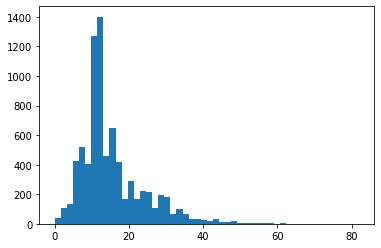

In [ ]:
# distrib of number of n-grams per artist name
SSS = np.asarray(X_b.sum(axis=1)).flatten()
plt.hist(SSS, bins=50);

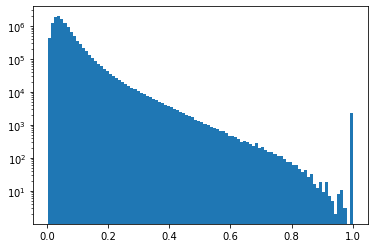

In [ ]:
plt.hist(X_inner.data, bins=100);
plt.yscale('log')

In [ ]:
# compare pairs of artist names
# use the cosine similarities to prioritize comparisons between artist names with high cosine similarity
candidate_matches_artists = []

for i, (idx_b, row_b) in tqdm(enumerate(artists_billb.iterrows()), total=artists_billb.shape[0]):
    
    # sort the indices in decreasing order of similarity and keep the first 100
    sims_i_idxs_sorted = np.asarray(X_inner[i].todense()).flatten().argsort()[::-1][:100]
    artist_name_b = row_b.Performer
    artist_id_b = row_b.SongID
    song_year_b = row_b.week.year
    song_week_b = row_b.week
    
    for j in sims_i_idxs_sorted:
  
        artist_name_w = artists_wasabi.iloc[j].artist_name
        artist_id_w = artists_wasabi.iloc[j].artist_id
        song_year_w = int(artists_wasabi.iloc[j].song_year_combined)
        song_pubdate_w = artists_wasabi.iloc[j].song_pubdate_combined
        
        # run the method in name_normalizer
        is_same_artist = name_normalizer.same_artist(artist_name_w, artist_name_b, with_rotation=False, rotate_stopw=True)
        
        if is_same_artist:
            candidate_matches_artists.append([artist_name_w, artist_name_b, artist_id_w, artist_id_b,
                                              song_year_w, song_year_b, song_pubdate_w, song_week_b])
        
candidate_matches_artists = pd.DataFrame(candidate_matches_artists, columns=['artist_name_w', 'artist_name_b',
                                                                            'artist_id_w', 'artist_id_b',
                                                                             'song_year_w', 'song_year_b',
                                                                             'song_pubdate_w', 'song_week_b'])
candidate_matches_artists.head(3)


  0%|          | 0/7835 [00:00<?, ?it/s]

,artist_name_w,artist_name_b,artist_id_w,artist_id_b,song_year_w,song_year_b,song_pubdate_w,song_week_b
0,mariah carey,mariah carey,56d93894ce06f50c0fed7fea,All I Want For Christmas Is YouMariah Carey,1990,2000,1990-08-22,2000-01-08
1,brenda lee,brenda lee,56d8086653a7ddfc01f91826,Rockin' Around The Christmas TreeBrenda Lee,1991,1960,1991-10-28,1960-12-10
2,bobby helms,bobby helms,56d8068c53a7ddfc01f91559,Jingle Bell RockBobby Helms,1965,1959,,1959-01-03


In [ ]:
print('Number of billboard artists with match: ',
      candidate_matches_artists.drop_duplicates(subset=['artist_name_b']).shape[0])
print("Total number of billboard artists: ", artists_billb.shape[0])

Number of billboard artists with match:  3900
Total number of billboard artists:  7835


In [ ]:
# for each artist in Billboard, group all the matched in wasabi
# this groups the matched wasabi artists for each billboard artist
candidate_matches_artists = candidate_matches_artists.groupby(["artist_name_b", "artist_id_b", 
                                                               'song_year_b', 'song_week_b']).apply(lambda rows:
                             pd.Series({'artists_wasabi':[(art_id, art_name, song_year_w, song_pubdate_w) 
                              for art_name, art_id, song_year_w, song_pubdate_w in rows[['artist_name_w', 'artist_id_w', 
                                                                         'song_year_w', 'song_pubdate_w']].values]})).reset_index()

candidate_matches_artists.head(3)

,artist_name_b,artist_id_b,song_year_b,song_week_b,artists_wasabi
0,"""little"" jimmy dickens","May The Bird Of Paradise Fly Up Your Nose""Litt...",1965,1965-10-16,"[(56d85bb153a7ddfc01f99023, little jimmy dicke..."
1,50 cent,Straight To The Bank50 Cent,2007,2007-05-26,"[(57c92593e5c453a411c77256, 50 cent, 1999, 199..."
2,50 cent & olivia,Best Friend50 Cent & Olivia,2006,2006-03-11,"[(57c92593e5c453a411c77256, 50 cent, 1999, 199..."


In [ ]:
# print a sample of them
# there may be some false positives (e.g., "jonny cash" and "jonny nash")
candidate_matches_artists[candidate_matches_artists.artists_wasabi.apply(lambda l: len(l)>1)].sample(10, random_state=42)

,artist_name_b,artist_id_b,song_year_b,song_week_b,artists_wasabi
1013,"earth, wind & fire with the emotions","Boogie WonderlandEarth, Wind & Fire with The E...",1979,1979-05-12,"[(56d8252753a7ddfc01f94167, earth, wind & fire..."
3568,the teddy bears,Oh WhyThe Teddy Bears,1959,1959-03-07,"[(56d98519cc2ddd0c0f6bd69f, the teddy bears, 2..."
3329,the adventures,Broken LandThe Adventures,1988,1988-04-30,"[(56d97a55cc2ddd0c0f6bc844, the adventures, 19..."
195,b.o.b,Don't Let Me FallB.o.B,2010,2010-04-24,"[(56d7fe2653a7ddfc01f90960, b.o.b, 2007, ), (5..."
2170,love,My Little Red BookLove,1966,1966-04-30,"[(56d85e4453a7ddfc01f993d9, love, 1999, 1999-0..."
1788,jojo featuring bow wow,Baby It's YouJoJo Featuring Bow Wow,2004,2004-10-09,"[(56d84c1653a7ddfc01f978dc, jojo, 2001, ), (56..."
3441,the hives,Hate To Say I Told You SoThe Hives,2002,2002-07-20,"[(56d97f8bcc2ddd0c0f6bcec4, the hives, 1997, 1..."
1512,james otto,Just Got Started Lovin' YouJames Otto,2008,2008-03-08,"[(56d8457553a7ddfc01f96f8a, james otto, 2004, ..."
3652,tom petty,It's Good To Be KingTom Petty,1995,1995-04-29,"[(56d989c3cc2ddd0c0f6bdd50, tom petty, 1993, 1..."
241,barry mann,FeelingsBarry Mann,1970,1970-05-30,"[(56d7ffb553a7ddfc01f90bcb, barry mann, 1999, ..."


#### Match titles

In [ ]:
# for each artist in billboard, take the wasabi songs of all the matched artists in the previous step
# discard candidate matches if there is a difference higher than 1 year between the publication 
# date in wasabi and the first occurrence in billboard chart
candidate_matches_songs = []

for idx, row in tqdm(candidate_matches_artists.iterrows(), total=candidate_matches_artists.shape[0]):
    
    artist_name_b = row.artist_name_b 
    
    # get songs in billboard of artist_name_b
    songs_artist_b = song_info[song_info.Performer==artist_name_b]
    
    # take wasabi songs candidate match artist
    artists_w = row.artists_wasabi
    songs_artist_w = song_lyrics[song_lyrics.artist_id.isin([a_id[0] for a_id in artists_w])]
    
    for idx2, song_artist_b in songs_artist_b.iterrows():
        for idx3, song_artist_w in songs_artist_w.iterrows():
            
            title_b = song_artist_b.Song
            song_year_b = song_artist_b.week.year

            title_w = song_artist_w.song_title
            song_year_w = song_artist_w.song_year_combined

            # skip if the two songs published with more than 2 years of difference
            if abs(song_year_b - song_year_w)>=2:
                continue
            
            is_same_title = name_normalizer.same_title(title_b, title_w, check_diff_stopw=True)
            
            if is_same_title:
                
                song_id_b = song_artist_b.SongID
                song_id_w = song_artist_w.song_id
                artist_name_w = song_artist_w.artist_name
                
                candidate_matches_songs.append([song_id_b, song_id_w, title_b, title_w, artist_name_b, artist_name_w])
        
candidate_matches_songs = pd.DataFrame(candidate_matches_songs, 
                                       columns=['song_id_b', 'song_id_w', 
                                                'title_b', 'title_w', 
                                                'artist_name_b', 'artist_name_w'])



  0%|          | 0/3900 [00:00<?, ?it/s]

In [ ]:
# Note: one billboard song may be matched with more than 1 wasabi songs
print("Number of candidate matches: ", candidate_matches_songs.shape[0])
print("Number of unique songs in billboard: ", song_info.shape[0])

Number of candidate matches:  14319
Number of unique songs in billboard:  24180


In [ ]:
# add date from wasabi
candidate_matches_songs = pd.merge(candidate_matches_songs, 
                                    song_lyrics[['song_id', 'song_decade_combined', 'song_year_combined']].rename(columns={'song_id':'song_id_w'}), 
                                    on='song_id_w', how='left')

# add week from billboard
candidate_matches_songs = pd.merge(candidate_matches_songs,
                                   song_info[['SongID', 'week', 'WeekID']].rename(columns={'SongID':'song_id_b'}),
                                   on='song_id_b', how='left')

candidate_matches_songs.shape[0]

14319

In [ ]:
candidate_matches_songs.head()

,song_id_b,song_id_w,title_b,title_w,artist_name_b,artist_name_w,song_decade_combined,song_year_combined,week,WeekID
0,Straight To The Bank50 Cent,57c92594e5c453a411c772ef,straight to the bank,straight to the bank,50 cent,50 cent,2000,2007,2007-05-26,5/26/2007
1,Disco Inferno50 Cent,57c92594e5c453a411c772c8,disco inferno,disco inferno,50 cent,50 cent,2000,2005,2004-12-11,12/11/2004
2,P.I.M.P.50 Cent,57c92594e5c453a411c7729c,p.i.m.p.,p.i.m.p.,50 cent,50 cent,2000,2003,2003-05-31,5/31/2003
3,P.I.M.P.50 Cent,57c92594e5c453a411c772a5,p.i.m.p.,p.i.m.p. (remix),50 cent,50 cent,2000,2003,2003-05-31,5/31/2003
4,Get Up50 Cent,57c92594e5c453a411c77389,get up,get up,50 cent,50 cent,2000,2008,2008-11-01,11/1/2008


In [ ]:
# group all candidate matches for each song in billboard
candidate_matches_songs_grouped = candidate_matches_songs.groupby(["song_id_b", 'title_b', 'artist_name_b', 
                                                                   'week', 'WeekID']).apply(lambda rows:
                                                                    pd.Series({'songs_wasabi':[(id_, title_, artist_, song_year_combined)
                                            for id_, title_, artist_, song_year_combined in rows[['song_id_w', 'title_w', 'artist_name_w',
                                                                                'song_year_combined']].values]}) ).reset_index()

candidate_matches_songs_grouped.head(3)

,song_id_b,title_b,artist_name_b,week,WeekID,songs_wasabi
0,"""Joy"" Pt. IIsaac Hayes","""joy"" pt. i",isaac hayes,1973-12-22,12/22/1973,"[(5714ded425ac0d8aee451d3c, joy, isaac hayes, ..."
1,'03 Bonnie & ClydeJay-Z Featuring Beyonce Knowles,'03 bonnie and clyde,jay-z featuring beyonce knowles,2002-10-26,10/26/2002,"[(5714ded425ac0d8aee459dfe, '03 bonnie and cly..."
2,'65 Love AffairPaul Davis,'65 love affair,paul davis,1982-02-27,2/27/1982,"[(5714dedf25ac0d8aee4d80c5, '65 love affair, p..."


In [ ]:
print("Number of unique billboard songs with candidate matches: ", candidate_matches_songs_grouped.shape[0])
print("Number of unique songs in billboard: ", song_info.shape[0])

Number of unique billboard songs with candidate matches:  11024
Number of unique songs in billboard:  24180


In [ ]:
# count how many have more than 1 songs_wasabi
candidate_matches_songs_grouped.songs_wasabi.apply(lambda songs: len(songs)>1).sum()

2383

In [ ]:
# to disambiguate these cases, we keep the younger among the wasabi songs
candidate_matches_songs_grouped.loc[:, 'songs_wasabi_dedup'] = candidate_matches_songs_grouped.songs_wasabi.apply(lambda songs:
                                                                                            min(songs, key=lambda item:item[3]))


final_matches = candidate_matches_songs_grouped.merge(candidate_matches_songs_grouped.songs_wasabi_dedup.apply(lambda songs:
                                                pd.Series({'song_id_w':songs[0],
                                                          'title_w':songs[1],
                                                          'artist_name_w':songs[2],
                                                           'song_year_w':songs[3]})),
                                                      left_index=True, right_index=True)
final_matches.head(3)

,song_id_b,title_b,artist_name_b,week,WeekID,songs_wasabi,songs_wasabi_dedup,song_id_w,title_w,artist_name_w,song_year_w
0,"""Joy"" Pt. IIsaac Hayes","""joy"" pt. i",isaac hayes,1973-12-22,12/22/1973,"[(5714ded425ac0d8aee451d3c, joy, isaac hayes, ...","(5714ded425ac0d8aee451d3c, joy, isaac hayes, 1...",5714ded425ac0d8aee451d3c,joy,isaac hayes,1973
1,'03 Bonnie & ClydeJay-Z Featuring Beyonce Knowles,'03 bonnie and clyde,jay-z featuring beyonce knowles,2002-10-26,10/26/2002,"[(5714ded425ac0d8aee459dfe, '03 bonnie and cly...","(5714ded425ac0d8aee459dfe, '03 bonnie and clyd...",5714ded425ac0d8aee459dfe,'03 bonnie and clyde,jay-z,2002
2,'65 Love AffairPaul Davis,'65 love affair,paul davis,1982-02-27,2/27/1982,"[(5714dedf25ac0d8aee4d80c5, '65 love affair, p...","(5714dedf25ac0d8aee4d80c5, '65 love affair, pa...",5714dedf25ac0d8aee4d80c5,'65 love affair,paul davis,1981


In [ ]:
print("Final number of billboard songs matched: ", final_matches.shape[0])
print("Initial number of billboard songs: ", song_info.shape[0])

Final number of billboard songs matched:  11024
Initial number of billboard songs:  24180


In [ ]:
print("Number of Wasabi songs matched with more than 1 billboard song: ", final_matches.song_id_w.duplicated().sum())
print("Look at some example:")

# some of them are wrong matches...
final_matches[final_matches.song_id_w.duplicated(False)].sort_values("song_id_w")[:10]

Number of Wasabi songs matched with more than 1 billboard song:  25
Look at some example:


,song_id_b,title_b,artist_name_b,week,WeekID,songs_wasabi,songs_wasabi_dedup,song_id_w,title_w,artist_name_w,song_year_w
75,......And Roses And RosesAndy Williams,......and roses and roses,andy williams,1965-04-03,4/3/1965,"[(5714dec525ac0d8aee396d4e, and roses and rose...","(5714dec525ac0d8aee396d4e, and roses and roses...",5714dec525ac0d8aee396d4e,and roses and roses,andy williams,1966
6193,More And MoreAndy Williams,more and more,andy williams,1967-07-08,7/8/1967,"[(5714dec525ac0d8aee396d4e, and roses and rose...","(5714dec525ac0d8aee396d4e, and roses and roses...",5714dec525ac0d8aee396d4e,and roses and roses,andy williams,1966
10403,Where You LeadBarbra Streisand,where you lead,barbra streisand,1971-07-24,7/24/1971,"[(5714dec625ac0d8aee3a9600, where you lead, ba...","(5714dec625ac0d8aee3a9600, where you lead, bar...",5714dec625ac0d8aee3a9600,where you lead,barbra streisand,1971
8650,Sweet Inspiration/Where You LeadBarbra Streisand,sweet inspiration/where you lead,barbra streisand,1972-06-24,6/24/1972,"[(5714dec625ac0d8aee3a9600, where you lead, ba...","(5714dec625ac0d8aee3a9600, where you lead, bar...",5714dec625ac0d8aee3a9600,where you lead,barbra streisand,1971
9653,Tossin' And Turnin'Bobby Lewis,tossin' and turnin',bobby lewis,1961-04-22,4/22/1961,"[(5714dec825ac0d8aee3bbeca, tossin' and turnin...","(5714dec825ac0d8aee3bbeca, tossin' and turnin'...",5714dec825ac0d8aee3bbeca,tossin' and turnin',bobby lewis,1961
4494,I'm Tossin' And Turnin' AgainBobby Lewis,i'm tossin' and turnin' again,bobby lewis,1962-07-28,7/28/1962,"[(5714dec825ac0d8aee3bbeca, tossin' and turnin...","(5714dec825ac0d8aee3bbeca, tossin' and turnin'...",5714dec825ac0d8aee3bbeca,tossin' and turnin',bobby lewis,1961
1045,Blue On BlueBobby Vinton,blue on blue,bobby vinton,1963-05-18,5/18/1963,"[(5714dec825ac0d8aee3bc335, blue on blue, bobb...","(5714dec825ac0d8aee3bc335, blue on blue, bobby...",5714dec825ac0d8aee3bc335,blue on blue,bobby vinton,1963
1051,Blue VelvetBobby Vinton,blue velvet,bobby vinton,1963-08-10,8/10/1963,"[(5714dec825ac0d8aee3bc335, blue on blue, bobb...","(5714dec825ac0d8aee3bc335, blue on blue, bobby...",5714dec825ac0d8aee3bc335,blue on blue,bobby vinton,1963
4083,I Love YouDonna Summer,i love you,donna summer,1977-12-17,12/17/1977,"[(5714decd25ac0d8aee400499, i feel love, donna...","(5714decd25ac0d8aee400499, i feel love, donna ...",5714decd25ac0d8aee400499,i feel love,donna summer,1977
3956,I Feel LoveDonna Summer,i feel love,donna summer,1977-08-06,8/6/1977,"[(5714decd25ac0d8aee400499, i feel love, donna...","(5714decd25ac0d8aee400499, i feel love, donna ...",5714decd25ac0d8aee400499,i feel love,donna summer,1977


In [ ]:
print("Number of matches with exact same title and artist name: ", 
      final_matches[(final_matches.title_b==final_matches.title_w)&
                    (final_matches.artist_name_b==final_matches.artist_name_w)].shape[0])

print("Number of matches due to the approximate match: ",
      final_matches[~((final_matches.title_b==final_matches.title_w)&
                    (final_matches.artist_name_b==final_matches.artist_name_w))].shape[0]) 

Number of matches with exact same title and artist name:  8736
Number of matches due to the approximate match:  2288


In [ ]:
# save it 
final_matches.to_json("billboard_wasabi_mapping.json")

In [ ]:
# move to Drive
!cp billboard_wasabi_mapping.json drive/MyDrive/Artistic_Content_Creation/WASABI_gender_experiments/WASABI_gender_experiments_definitive/dataset_10/